
## Deep Learning Project - Gesture Recognition

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [2]:
# Importing the necessary libraries

import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)
#tf.random.set_seed

Using TensorFlow backend.


In [4]:
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [6]:
project_folder='Project_data'

##### Plotting

In [7]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [10]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [11]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_2 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 80, 80, 32)    128       
__________

##### Sample Cropping

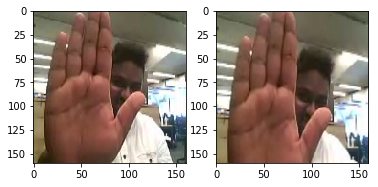

In [12]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

## Experimenting with Image resolution, number of frames to use and batch_size

In [13]:
#conv_3d1.train_model(conv_3d1_model)

### We had hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40...we get the below error

ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [13]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


##### So lets trade-off between these parameters

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [16]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
34/34 [==============================] - 193s 6s/step - loss: 1.6084 - categorical_accuracy: 0.4150 - val_loss: 1.9005 - val_categorical_accuracy: 0.4600

Epoch 00001: val_loss improved from inf to 1.90045, saving model to model_init_2021-02-0708_16_44.362244/model-00001-1.63165-0.40875-1.90045-0.46000.h5
Epoch 2/2
34/34 [==============================] - 70s 2s/step - loss: 1.0581 - categorical_accuracy: 0.5909 - val_loss: 0.9163 - val_categorical_accuracy: 0.6700

Epoch 00002: val_loss improved from 1.90045 to 0.91630, saving model to model_init_2021-02-0708_16_44.362244/model-00002-1.04424-0.59729-0.91630-0.67000.h5


In [17]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - 92s 2s/step - loss: 1.6415 - categorical_accuracy: 0.3925 - val_loss: 0.9396 - val_categorical_accuracy: 0.6200

Epoch 00001: val_loss improved from inf to 0.93955, saving model to model_init_2021-02-0708_21_12.793672/model-00001-1.64842-0.38763-0.93955-0.62000.h5
Epoch 2/2
45/45 [==============================] - 80s 2s/step - loss: 1.2686 - categorical_accuracy: 0.5304 - val_loss: 1.5869 - val_categorical_accuracy: 0.4700

Epoch 00002: val_loss did not improve from 0.93955


In [18]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
23/23 [==============================] - 52s 2s/step - loss: 1.6337 - categorical_accuracy: 0.4083 - val_loss: 2.1356 - val_categorical_accuracy: 0.3800

Epoch 00001: val_loss improved from inf to 2.13561, saving model to model_init_2021-02-0708_24_11.218304/model-00001-1.62171-0.39819-2.13561-0.38000.h5
Epoch 2/2
23/23 [==============================] - 43s 2s/step - loss: 1.0947 - categorical_accuracy: 0.5621 - val_loss: 1.3890 - val_categorical_accuracy: 0.4500

Epoch 00002: val_loss improved from 2.13561 to 1.38898, saving model to model_init_2021-02-0708_24_11.218304/model-00002-1.12135-0.55807-1.38898-0.45000.h5


- As we see from the above experiments **"image resolution"** and **number of frames** in sequence have more impact on training time than **batch_size**
- We can consider the Batch Size around 15-40
- We will change the resoulution 160X160, 120X120 according the model performance


## Model 1
### Base Model - Batch Size = 40 and No. of Epochs = 15

In [19]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_25 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_25 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_26 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 10, 80, 80, 32)    128       
__________

In [21]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - 72s 4s/step - loss: 1.6009 - categorical_accuracy: 0.3715 - val_loss: 5.2725 - val_categorical_accuracy: 0.2700

Epoch 00001: val_loss improved from inf to 5.27251, saving model to model_init_2021-02-0708_31_17.365805/model-00001-1.60489-0.37104-5.27251-0.27000.h5
Epoch 2/15
17/17 [==============================] - 52s 3s/step - loss: 1.0393 - categorical_accuracy: 0.6154 - val_loss: 1.2588 - val_categorical_accuracy: 0.5200

Epoch 00002: val_loss improved from 5.27251 to 1.25879, saving model to model_init_2021-02-0708_31_17.365805/model-00002-1.04874-0.61237-1.25879-0.52000.h5
Epoch 3/15
17/17 [==============================] - 57s 3s/step - loss: 0.7361 - categorical_accuracy: 0.7159 - val_loss: 0.7708 - val_categorical_accuracy: 0.6800

Epoch 00003: val_loss improved from 1.25879 to 0.77080, saving model to model_init_2021-02-0708_31_17.365805/model-00003-0.73815-0.71644-0.77080-0.68000.h5
Epoch 4/15
17/17 [=

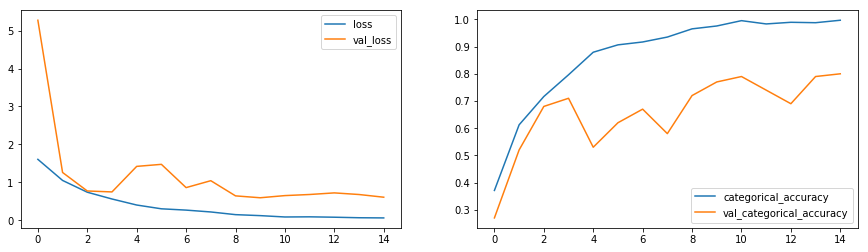

In [22]:
plot(history_model1)

##### Model is clearly overfitting. :(

## Model 2  
### Adding dropout layers - Batch Size = 20 and No. of Epochs = 25

In [23]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_29 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_29 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_30 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 10, 80, 80, 32)    128       
__________

In [24]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - 124s 4s/step - loss: 1.7818 - categorical_accuracy: 0.4165 - val_loss: 6.6889 - val_categorical_accuracy: 0.2400

Epoch 00001: val_loss improved from inf to 6.68886, saving model to model_init_2021-02-0708_49_08.434504/model-00001-1.78807-0.41026-6.68886-0.24000.h5
Epoch 2/25
34/34 [==============================] - 113s 3s/step - loss: 1.3650 - categorical_accuracy: 0.5250 - val_loss: 9.0454 - val_categorical_accuracy: 0.2300

Epoch 00002: val_loss did not improve from 6.68886
Epoch 3/25
34/34 [==============================] - 122s 4s/step - loss: 1.2273 - categorical_accuracy: 0.5732 - val_loss: 6.9485 - val_categorical_accuracy: 0.2700

Epoch 00003: val_loss did not improve from 6.68886
Epoch 4/25
34/34 [==============================] - 129s 4s/step - loss: 0.9042 - categorical_accuracy: 0.6556 - val_loss: 1.3381 - val_categorical_accuracy: 0.6200

Epoch 00004: val_loss improved from 6.68886 to 1.33809, savi

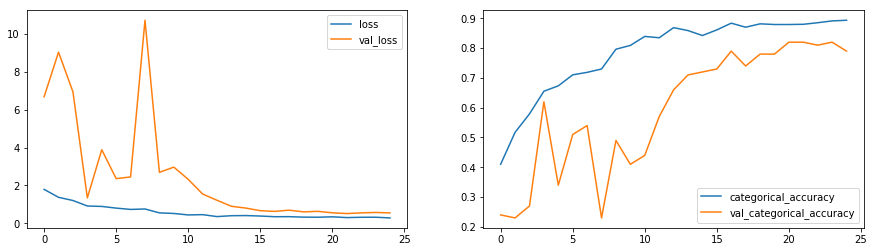

In [25]:
plot(history_model2)

- Best weights save automatically. The validation accuracy of 81% and training accuracy of 87%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations  in loss, let's try lowering the learning rate to 0.0002

## Model 3 
### Reduce filter size to (2,2,2) and image res to 120 x  120, - Batch Size = 30 and No. of Epochs = 25

In [26]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [27]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_33 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_33 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_34 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 8, 60, 60, 32)     128       
__________

In [28]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - 96s 4s/step - loss: 2.2475 - categorical_accuracy: 0.3367 - val_loss: 1.2874 - val_categorical_accuracy: 0.5100

Epoch 00001: val_loss improved from inf to 1.28742, saving model to model_init_2021-02-0709_45_10.787497/model-00001-2.26177-0.33032-1.28742-0.51000.h5
Epoch 2/25
23/23 [==============================] - 83s 4s/step - loss: 1.6979 - categorical_accuracy: 0.4364 - val_loss: 1.1060 - val_categorical_accuracy: 0.6000

Epoch 00002: val_loss improved from 1.28742 to 1.10601, saving model to model_init_2021-02-0709_45_10.787497/model-00002-1.65010-0.44042-1.10601-0.60000.h5
Epoch 3/25
23/23 [==============================] - 88s 4s/step - loss: 1.5172 - categorical_accuracy: 0.4933 - val_loss: 0.9779 - val_categorical_accuracy: 0.6600

Epoch 00003: val_loss improved from 1.10601 to 0.97788, saving model to model_init_2021-02-0709_45_10.787497/model-00003-1.42211-0.50603-0.97788-0.66000.h5
Epoch 4/25
23/23 [=

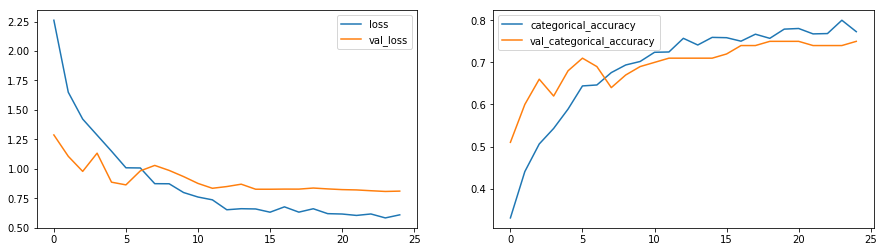

In [29]:
plot(history_model3)

##### Model has a  best validation accuracy of 75% and training accuracy of 76% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

## Model 4 - 
### Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [30]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [31]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_37 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_37 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_38 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_38 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_52 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_37 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [32]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - 116s 3s/step - loss: 2.0365 - categorical_accuracy: 0.3466 - val_loss: 6.4968 - val_categorical_accuracy: 0.3300

Epoch 00001: val_loss improved from inf to 6.49679, saving model to model_init_2021-02-0710_30_48.813196/model-00001-2.03610-0.34691-6.49679-0.33000.h5
Epoch 2/25
34/34 [==============================] - 94s 3s/step - loss: 1.7801 - categorical_accuracy: 0.3871 - val_loss: 6.6722 - val_categorical_accuracy: 0.2900

Epoch 00002: val_loss did not improve from 6.49679
Epoch 3/25
34/34 [==============================] - 94s 3s/step - loss: 1.4026 - categorical_accuracy: 0.4886 - val_loss: 2.7888 - val_categorical_accuracy: 0.4600

Epoch 00003: val_loss improved from 6.49679 to 2.78881, saving model to model_init_2021-02-0710_30_48.813196/model-00003-1.39961-0.49246-2.78881-0.46000.h5
Epoch 4/25
34/34 [==============================] - 94s 3s/step - loss: 1.2660 - categorical_accuracy: 0.5688 - val_loss: 1

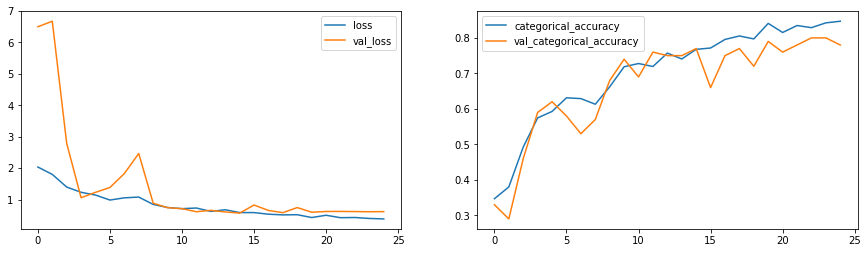

In [34]:
plot(history_model4)

- Last Epoch stop on 25/25!! earlystopping started but very late

##### With more layers we dont see much performance improvement. We get a best validation accuracy of 76% . Let's try adding dropouts at the convolution layers

## Model 5 
### Adding dropout at convolution layers

In [35]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [36]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_45 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_45 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_46 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_46 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_41 (MaxPooling (None, 8, 60, 60, 16)     0         
__________

In [37]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 [==============================] - 105s 3s/step - loss: 1.7703 - categorical_accuracy: 0.3650 - val_loss: 2.4620 - val_categorical_accuracy: 0.4400

Epoch 00001: val_loss improved from inf to 2.46195, saving model to model_init_2021-02-0711_16_02.132981/model-00001-1.76066-0.37406-2.46195-0.44000.h5
Epoch 2/15
34/34 [==============================] - 95s 3s/step - loss: 1.3587 - categorical_accuracy: 0.4978 - val_loss: 1.7426 - val_categorical_accuracy: 0.5600

Epoch 00002: val_loss improved from 2.46195 to 1.74257, saving model to model_init_2021-02-0711_16_02.132981/model-00002-1.35293-0.49774-1.74257-0.56000.h5
Epoch 3/15
34/34 [==============================] - 95s 3s/step - loss: 1.2374 - categorical_accuracy: 0.5423 - val_loss: 1.1315 - val_categorical_accuracy: 0.6200

Epoch 00003: val_loss improved from 1.74257 to 1.13147, saving model to model_init_2021-02-0711_16_02.132981/model-00003-1.23065-0.54751-1.13147-0.62000.h5
Epoch 4/15
34/34 [

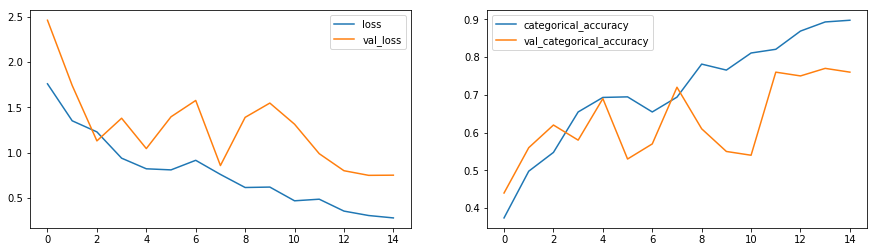

In [38]:
plot(history_model5)

Overfitting again, Adding dropouts has further reduced validation accuracy gap as the model doesn't seem to generalise well

##### All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

## Model 6 
### Reducing the number of parameters

In [39]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [40]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_53 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_53 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_71 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_45 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_54 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_54 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_72 (Batc (None, 8, 50, 50, 32)     128       
__________

In [41]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/20
34/34 [==============================] - 81s 2s/step - loss: 1.8117 - categorical_accuracy: 0.3473 - val_loss: 1.3454 - val_categorical_accuracy: 0.5400

Epoch 00001: val_loss improved from inf to 1.34539, saving model to model_init_2021-02-0711_43_19.249004/model-00001-1.83717-0.33937-1.34539-0.54000.h5
Epoch 2/20
34/34 [==============================] - 68s 2s/step - loss: 1.2083 - categorical_accuracy: 0.5390 - val_loss: 0.8808 - val_categorical_accuracy: 0.6500

Epoch 00002: val_loss improved from 1.34539 to 0.88076, saving model to model_init_2021-02-0711_43_19.249004/model-00002-1.19512-0.53997-0.88076-0.65000.h5
Epoch 3/20
34/34 [==============================] - 74s 2s/step - loss: 1.0618 - categorical_accuracy: 0.5964 - val_loss: 0.9477 - val_categorical_accuracy: 0.6300

Epoch 00003: val_loss did not improve from 0.88076
Epoch 4/20
34/34 [==============================] - 75s 2s/step - loss: 0.9086 - categorical_accuracy: 0.6626 - val_loss: 0.7

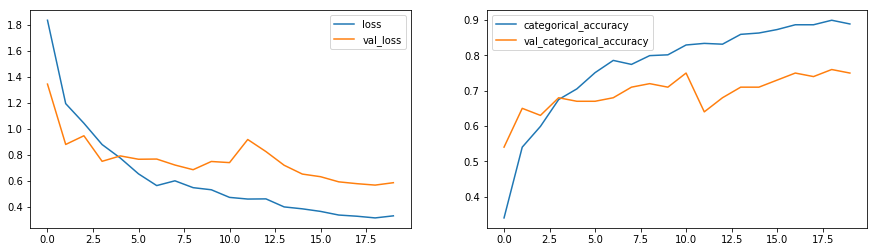

In [42]:
plot(history_model6)

###### For the above low memory foot print model, we get the best validation accuracy of 76%

## Model 7 - Reducing the number of parameters again

In [43]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [44]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_57 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_57 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_77 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_49 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_58 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_78 (Batc (None, 8, 60, 60, 32)     128       
__________

In [45]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - 85s 2s/step - loss: 1.8645 - categorical_accuracy: 0.3186 - val_loss: 1.4536 - val_categorical_accuracy: 0.4800

Epoch 00001: val_loss improved from inf to 1.45364, saving model to model_init_2021-02-0712_20_36.485544/model-00001-1.89041-0.30995-1.45364-0.48000.h5
Epoch 2/25
34/34 [==============================] - 74s 2s/step - loss: 1.3398 - categorical_accuracy: 0.4812 - val_loss: 1.4252 - val_categorical_accuracy: 0.4900

Epoch 00002: val_loss improved from 1.45364 to 1.42516, saving model to model_init_2021-02-0712_20_36.485544/model-00002-1.31743-0.49321-1.42516-0.49000.h5
Epoch 3/25
34/34 [==============================] - 80s 2s/step - loss: 1.2142 - categorical_accuracy: 0.5298 - val_loss: 1.2022 - val_categorical_accuracy: 0.5700

Epoch 00003: val_loss improved from 1.42516 to 1.20215, saving model to model_init_2021-02-0712_20_36.485544/model-00003-1.19934-0.53469-1.20215-0.57000.h5
Epoch 4/25
34/34 [==

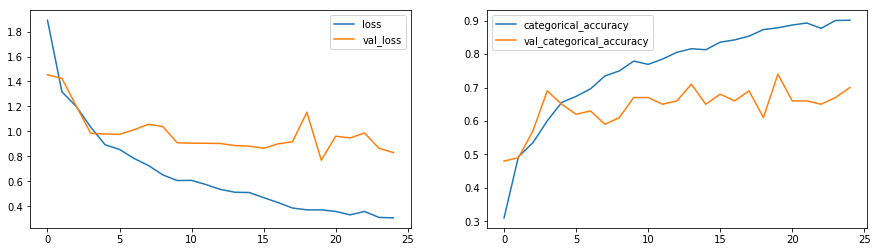

In [46]:
plot(history_model7)

###### For the above low memory foot print model the best validation accuracy of 74%

## Model 8 - CNN- LSTM Model

In [47]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [48]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [49]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - 104s 3s/step - loss: 1.4115 - categorical_accuracy: 0.3893 - val_loss: 1.6325 - val_categorical_accuracy: 0.3300

Epoch 00001: val_loss improved from inf to 1.63254, saving model to model_init_2021-02-0713_09_02.748872/model-00001-1.40770-0.39065-1.63254-0.33000.h5
Epoch 2/20
34/34 [==============================] - 88s 3s/step - loss: 1.1866 - categorical_accuracy: 0.4838 - val_loss: 1.2993 - val_categorical_accuracy: 0.4700

Epoch 00002: val_loss improved from 1.63254 to 1.29930, saving model to model_init_2021-02-0713_09_02.748872/model-00002-1.18755-0.48341-1.29930-0.47000.h5
Epoch 3/20
34/34 [==============================] - 95s 3s/step - loss: 1.0636 - categorical_accuracy: 0.5607 - val_loss: 1.1062 - val_categorical_accuracy: 0.5900

Epoch 00003: val_loss improved from 1.29930 to 1.10617, saving model to model_init_2021-02-0713_09_02.748872/model-00003-1.04894-0.56637-1.10617-0.59000.h5
Epoch 4/20
34/34 [

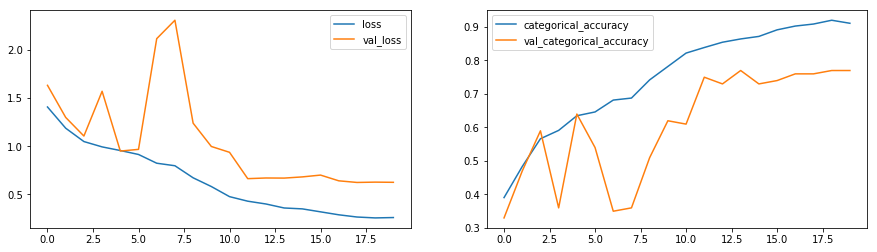

In [50]:
plot(history_model8)

##### For CNN - LSTM model we get a best validation accuracy of 76%

As we see more cases of overfitting, lets augment the data with ***slight rotation*** as well and run the same set of models again

## Let's apply some data augmentation & check the model performance.

In [9]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    
    

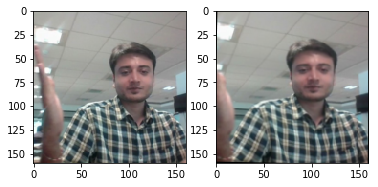

In [10]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])   

## Model 9 with Augmentation
### (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [11]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [12]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=160,image_width=160)
conv_3d9.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_2 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 80, 80, 32)    128       
__________

In [13]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 3638981
Epoch 1/20
34/34 [==============================] - 263s 8s/step - loss: 2.0711 - categorical_accuracy: 0.3447 - val_loss: 1.2536 - val_categorical_accuracy: 0.5300

Epoch 00001: saving model to model_init_2021-02-0714_29_51.917982/model-00001-2.06117-0.34087-1.25361-0.53000.h5
Epoch 2/20
34/34 [==============================] - 124s 4s/step - loss: 1.6146 - categorical_accuracy: 0.4511 - val_loss: 1.1017 - val_categorical_accuracy: 0.6100

Epoch 00002: saving model to model_init_2021-02-0714_29_51.917982/model-00002-1.62905-0.44570-1.10169-0.61000.h5
Epoch 3/20
34/34 [==============================] - 126s 4s/step - loss: 1.4707 - categorical_accuracy: 0.4934 - val_loss: 0.9048 - val_categorical_accuracy: 0.6500

Epoch 00003: saving model to model_init_2021-02-0714_29_51.917982/model-00003-1.45686-0.49321-0.90478-0.65000.h5
Epoch 4/20
34/34 [==============================] - 124s 4s/step - loss: 1.2704 - categorical_accuracy: 0.5721 - val_loss: 0.8276 - val_categ

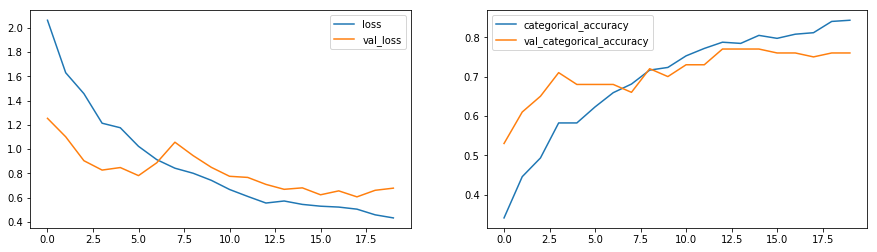

In [14]:
plot(history_model9)

## Model 10 with Augmentation
### (2,2,2) Filter  & 120x120 Image resolution - similar to Model 3

In [18]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=120,image_width=120)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_5 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_6 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 60, 60, 32)     128       
__________

In [17]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - 135s 6s/step - loss: 2.1243 - categorical_accuracy: 0.3345 - val_loss: 1.9330 - val_categorical_accuracy: 0.4900

Epoch 00001: saving model to model_init_2021-02-0715_19_29.121130/model-00001-2.15148-0.32805-1.93295-0.49000.h5
Epoch 2/25
23/23 [==============================] - 82s 4s/step - loss: 1.5557 - categorical_accuracy: 0.4466 - val_loss: 1.2388 - val_categorical_accuracy: 0.6500

Epoch 00002: saving model to model_init_2021-02-0715_19_29.121130/model-00002-1.56407-0.45098-1.23876-0.65000.h5
Epoch 3/25
23/23 [==============================] - 83s 4s/step - loss: 1.3851 - categorical_accuracy: 0.5279 - val_loss: 1.3907 - val_categorical_accuracy: 0.6200

Epoch 00003: saving model to model_init_2021-02-0715_19_29.121130/model-00003-1.35411-0.53544-1.39075-0.62000.h5
Epoch 4/25
23/23 [==============================] - 83s 4s/step - loss: 1.1825 - categorical_accuracy: 0.5761 - val_loss: 1.2252 - val_categori

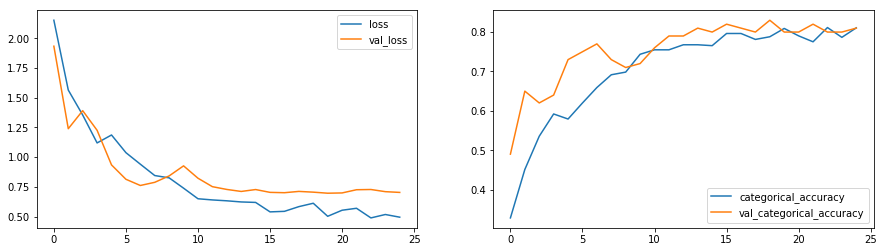

In [19]:
plot(history_model10)

### Best results! 81% Training accuracy and 81% validation accuracy

# Consolidated Final Models

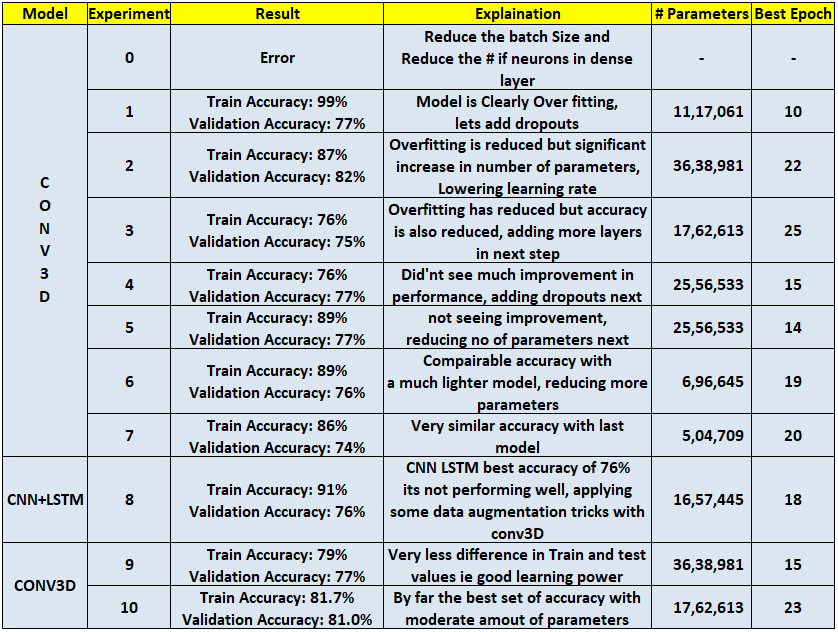

## After doing all the experiments, we finalized Model 10 - CONV3D, which performed well.
__Reason:__

__- (Training Accuracy : 81%, Validation Accuracy : 81%)__

__- Number of Parameters(1,7,62,613)less according to other models performance__


__The best weights of CNN-LSTM: model-00025-0.49426-0.81071-0.70273-0.81000.h5 (21.2 MB). we considered this weight for model testing, Let's have look at the performance below__


# Loading model and Testing If working or not

In [21]:
import time
from keras.models import load_model
model = load_model('model_init_2021-02-0715_19_29.121130/model-00025-0.49426-0.81071-0.70273-0.81000.h5')

In [22]:
test_generator=ModelConv3D10()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)



# conv_3d10=ModelConv3D10()
# conv_3d10.initialize_path(project_folder)
# conv_3d10.initialize_image_properties(image_height=120,image_width=120)
# conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
# conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
# conv_3d10_model.summary()

In [23]:
batch_labels

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [24]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[3 4 4 2 1 0 2 1 2 1 2 1 3 2 0 1 3 3 2 3 3 4 4 1 1 2 3 3 0 4]


# We are able to load model and predict from it without error

# END